# Show detailed distribution of the main VASCA selection variables
Enter the main notebook settings below.

In [1]:
region_name = "TDS" #_ELAISN1
obs_filter_id = 1  # 1 = NUV, 2 = FUV

In [2]:
%matplotlib widget
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from scipy.stats import chi2

from regions import CircleSkyRegion
from astropy import units as uu
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import pixel_to_skycoord
from astropy.table import Table,Column
import numpy as np

from vasca.region import Region
from vasca.field import BaseField
import vasca.visualization as vvis

from vasca.utils import mag2flux, flux2mag, select_obs_filter
from vasca.tables_dict import dd_vasca_columns

region_fname = "./vasca_pipeline/"+region_name+"/region_"+region_name+".fits"
rg = Region()
rg.load_from_fits(region_fname)
rg.add_column("tt_sources", "mag", flux2mag(rg.tt_sources["flux"].quantity).value)
tt_srcs = select_obs_filter(rg.tt_sources,obs_filter_id)

display(tt_srcs)
print("Nr. sources:",len(tt_srcs),"/",tt_srcs["sel"].sum())

Warning, some input fluxes <0, returning np.nan for them


fd_src_id,nr_det,ra,dec,pos_err,pos_xv,pos_var,pos_cpval,pos_rchiq,assoc_id,assoc_dist,obs_filter_id,sel,flux,flux_err,flux_nxv,flux_var,flux_cpval,flux_rchiq,assoc_ffactor,assoc_fdiff_s2n,rg_fd_id,rg_src_id,nr_fd_srcs,mag
,,deg,deg,arcsec,arcsec2,arcsec2,,,,arcsec,,,1e-06 Jy,1e-06 Jy,,1e-12 Jy2,,,,,,,,mag
int32,int32,float64,float64,float32,float32,float32,float32,float32,int64,float32,int32,bool,float32,float32,float32,float32,float32,float32,float32,float32,int64,int32,int32,float32
-1,29,214.91722520247603,52.64984713625541,0.12614775,-0.025411831,0.5919182,0.27031988,0.8572256,603,0.17844276,1,False,5.672066,0.14587975,-0.004768837,0.5198275,0.77876323,0.7876596,0.95457876,-1.3766985,-1,0,5,22.015648
-1,15,334.8059301442484,0.3645554858232876,0.17709391,-0.047009986,0.6110134,0.20351729,0.9748277,2,0.22115901,1,False,7.7551584,0.2594095,-0.0031997503,0.85309404,0.70699847,0.7665262,0.87222266,-3.9120905,-1,1,4,21.676023
-1,45,334.7918988211132,0.33575434285482975,0.10561045,-0.24676651,0.30226842,0.9790393,0.5426693,4,0.15787476,1,False,6.833859,0.13300695,0.0017846386,0.9343151,0.24741884,1.1362754,0.9139878,-3.688263,-1,2,4,21.813335
-1,31,334.7201622371709,0.42816411249370984,0.1235901,-0.33131674,0.2609972,0.930357,0.43386433,6,0.19899774,1,False,5.9115443,0.15287091,0.00074042997,0.7940439,0.7153575,0.8399306,0.9895234,-0.33424982,-1,3,4,21.970747
-1,3,334.7129557167112,0.43778340406340815,0.3093816,-0.03605604,0.5404953,0.18671753,0.9732201,7,0.32031628,1,False,10.898205,0.67920357,0.010084135,2.5977006,0.17285568,1.7552983,0.920166,-1.3634124,-1,4,4,21.306612
-1,58,334.6976887519119,0.39864432598151217,0.07526468,-0.19900717,0.15353711,0.99947304,0.4313008,9,0.05436181,1,False,39.676105,0.18516028,0.001055406,3.6995363,6.1504215e-05,1.8844998,0.98387516,-2.6852534,-1,5,4,19.903677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-1,2,34.486788795015265,-3.8877659253379044,0.47765177,-0.26606047,0.19043691,0.2693087,0.41716978,-1,-1.0,1,False,10.121385,0.6246569,0.10899746,11.974041,0.0001184039,14.817938,-100.0,-10000.0,-1,123018,1,21.3869


Nr. sources: 123024 / 1030


### Look into more details for the chisquare distribution

Text(0.5, 0, 'Reduced chisquare')

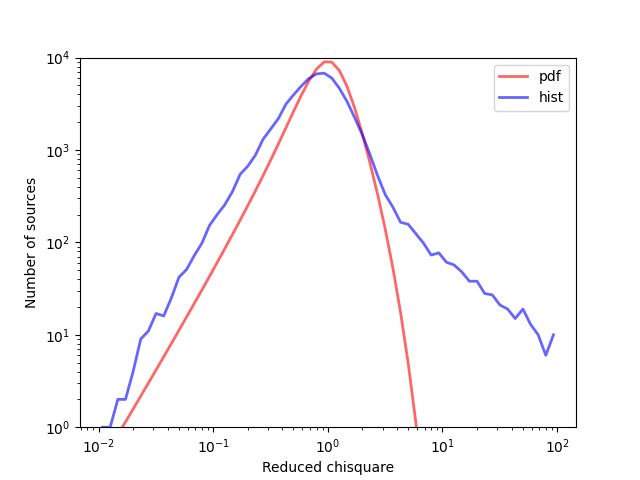

In [3]:
#Setup binning
rchisq_bins_lg = np.linspace(-2, 2, 61)
rchisq_bins = np.power(10,rchisq_bins_lg)
rchisq_bins_mean = (rchisq_bins[:-1]+rchisq_bins[1:])/2.
rchisq_bins_width = rchisq_bins[1:]-rchisq_bins[:-1]

#Select events
sel_det = tt_srcs["nr_det"]>4

#Calculate expected rchiq distribution for selected events
rchsq_pdf = np.zeros(len(rchisq_bins_mean))
#Get summed reduced chisquare distribution
for src in tt_srcs[sel_det]:
    rchsq_pdf += chi2.pdf(rchisq_bins_mean, src["nr_det"]-1, scale = 1/(src["nr_det"]-1) )*rchisq_bins_width 

rchiq_hist, bins = np.histogram(tt_srcs[sel_det]["flux_rchiq"], bins = rchisq_bins)

fig_rchsq = plt.figure()
plt.loglog(rchisq_bins_mean, rchsq_pdf ,'r-', lw=2, alpha=0.6, label='pdf')
plt.loglog(rchisq_bins_mean, rchiq_hist ,'b-', lw=2, alpha=0.6, label='hist')
plt.ylim(1e-0,1e4)
plt.legend()
plt.ylabel("Number of sources")
plt.xlabel("Reduced chisquare")

### Look at the Pval distibutions for constant flux and position for different magnitudes

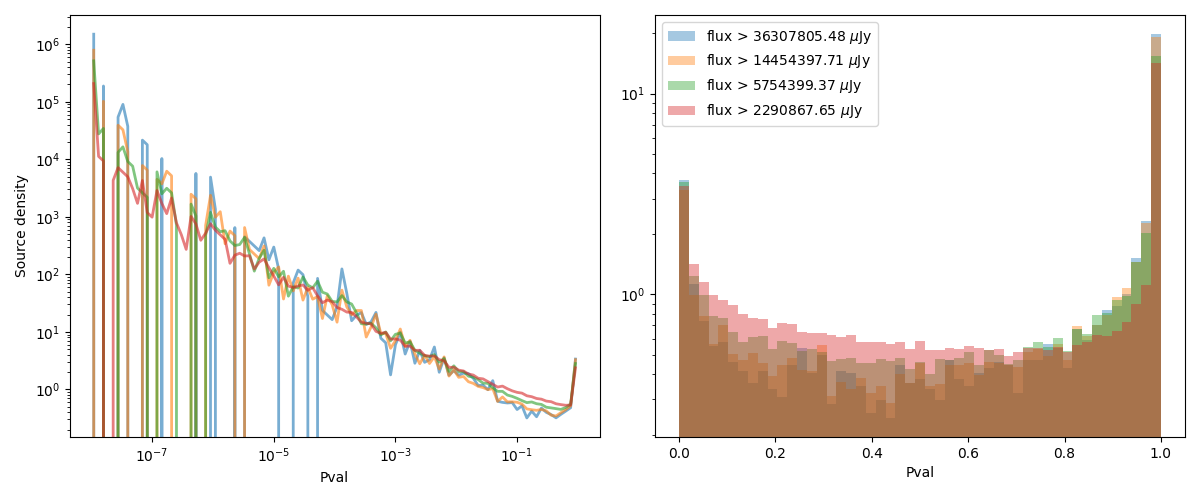

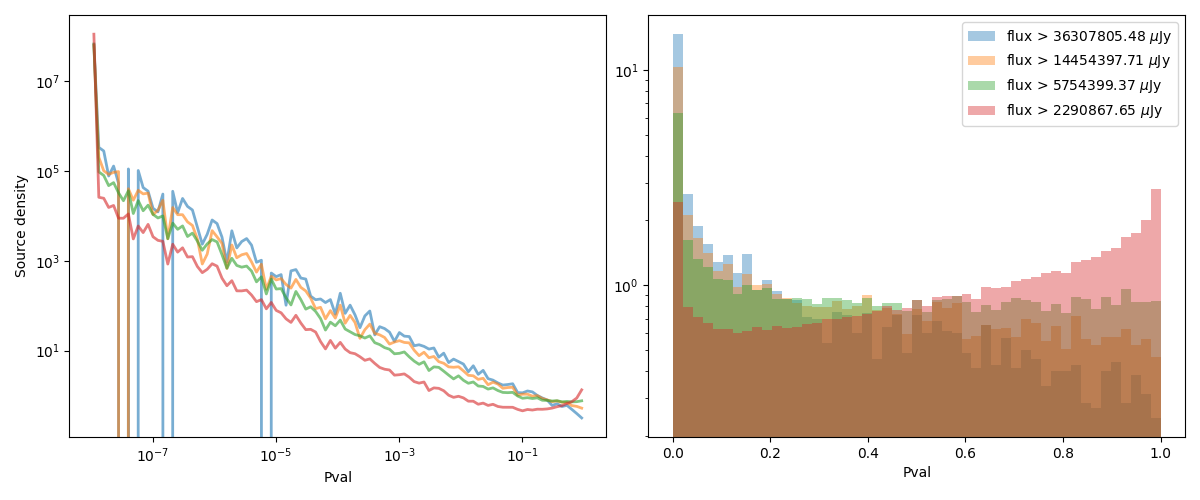

In [4]:
#Get pval data and saturate it at low Pval for better plotting
var_cpval = ["pos","flux"] #"pos" # 
pval_min = 1e-8
for var in var_cpval:
    pvals = tt_srcs[var+"_cpval"]
    pvals = (pvals<pval_min+1e-12)*(pval_min+1e-12)+(pvals>pval_min)*pvals

    #if plot_logx:
    pval_bins_lg = np.linspace(np.log10(pval_min), 0, 101)
    pval_bins = np.power(10,pval_bins_lg)
    pval_bins_mean = (pval_bins[:-1]+pval_bins[1:])/2.
    
    pval_bins_lin = np.linspace(0, 1, 50)

    #Plotting for different magnitude cuts
    fig_pval, axs = plt.subplots(1, 2, figsize=(12, 5), squeeze=False, num=var)
    axs = axs.flatten()
    flux_range = mag2flux(range(20,24))
    for flux_cut in flux_range:
        sel_flux = (tt_srcs["flux"].quantity>flux_cut)

        pval_hist, bins = np.histogram(pvals[sel_flux], bins=pval_bins, density=True)
        axs[0].loglog(pval_bins_mean, pval_hist , lw=2, alpha=0.6, label=str(flux_cut))
        str_cut = str(round(flux_cut.value*1e6,2)) 
        axs[1].hist(tt_srcs[sel_flux][var+"_cpval"], bins=pval_bins_lin, density=True ,label=r"flux > "+str_cut+" $\mu$Jy",alpha=0.4)   #, ,cumulative=1


    axs[0].set_ylabel("Source density")
    axs[0].set_xlabel("Pval")
    axs[1].set_xlabel("Pval")
    plt.legend()
    plt.tight_layout()
    plt.semilogy()

### Reproduce Fig. 3 from Gezari et al. ApJ 2013

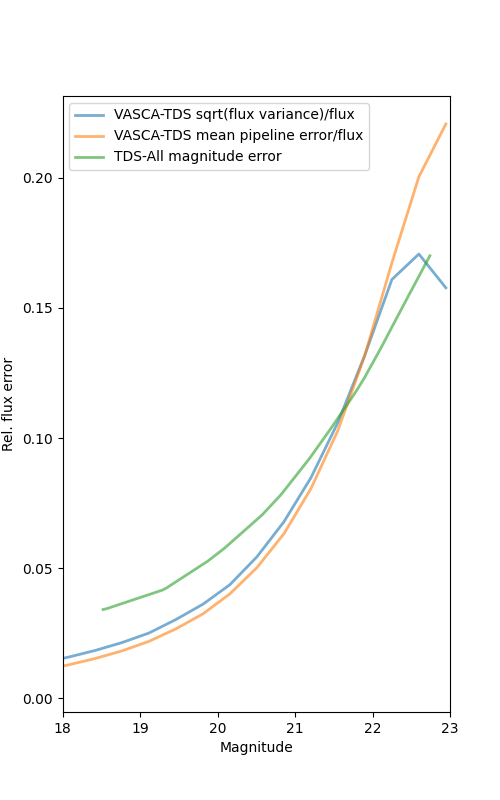

In [14]:
#Source selection
sel_cpval = tt_srcs["flux_cpval"]>0.001 #-1
#rg.tt_fields.add_index("field_id")
#fd = rg.tt_fields.loc["field_id", "GNU2605053246158405632"]
#sel_field = tt_srcs["rg_fd_id"]==fd["rg_fd_id"]
sel_ndet = tt_srcs["nr_det"]>10
sel_all = sel_cpval*sel_ndet#*sel_field

flux_var_wght = np.sqrt(tt_srcs["flux_var"][sel_all])/tt_srcs["flux"][sel_all]
flux_var_hist, var_bins = np.histogram(tt_srcs["mag"][sel_all], bins=20, density=False, weights = flux_var_wght )
flux_rel_err_wght = tt_srcs["flux_err"][sel_all]*np.sqrt(tt_srcs["nr_det"][sel_all])/tt_srcs["flux"][sel_all]
flux_relerr_hist, var_bins = np.histogram(tt_srcs["mag"][sel_all], bins=var_bins, density=False, weights = flux_rel_err_wght)
flux_var_entries, bins = np.histogram(tt_srcs["mag"][sel_all], bins=var_bins, density=False)
var_bins_mean = (var_bins[:-1]+var_bins[1:])/2.

#Get TDS Fig 3 data
tt_tds= Table.read("./resources/TDS-ApJ_766_60/GezariApJ2013_TDS_Fig3.csv")

#Plot
fig_mag_var = plt.figure(figsize=(5, 8))
plt.plot(var_bins_mean , flux_var_hist/flux_var_entries ,lw=2, alpha=0.6, label="VASCA-TDS sqrt(flux variance)/flux")
plt.plot(var_bins_mean , flux_relerr_hist/flux_var_entries ,lw=2, alpha=0.6, label="VASCA-TDS mean pipeline error/flux")
#plt.plot(tt_tds["mag"] , tt_tds["MOS23"] ,lw=2, alpha=0.6, label="TDS-MOS23")
plt.plot(tt_tds["mag"] , tt_tds["TDS"] ,lw=2, alpha=0.6, label="TDS-All magnitude error")
plt.xlabel("Magnitude")
plt.ylabel("Rel. flux error")
plt.legend()
plt.xlim([18, 23])
fig_mag_var.savefig("./vasca_pipeline/"+region_name+"/vasca_"+region_name+"_mag_err.png")
#plt.semilogy()

In [6]:
### Angular resolution comparison distribution to errors

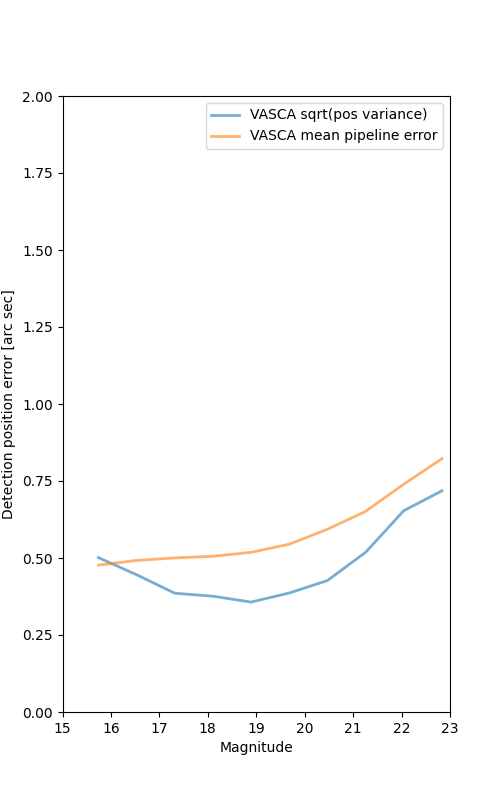

In [7]:
#Source selection
sel_cpval = tt_srcs["flux_cpval"]>0.01
#sel_field = tt_srcs["rg_fd_id"]==fd["rg_fd_id"]
sel_ndet = tt_srcs["nr_det"]>4
#sel_all = np.ones(len(tt_srcs),dtype=bool) # sel_cpval*sel_ndet*sel_field

pos_var_hist, var_bins = np.histogram(tt_srcs["mag"][sel_det], bins=10, density=False, weights = np.sqrt(tt_srcs["pos_var"][sel_det]) )
pos_err_hist, var_bins = np.histogram(tt_srcs["mag"][sel_det], bins=10, density=False, weights = tt_srcs["pos_err"][sel_det]*np.sqrt(tt_srcs["nr_det"][sel_det]))
pos_var_entries, bins = np.histogram(tt_srcs["mag"][sel_det], bins=var_bins, density=False)
pos_bins_mean = (var_bins[:-1]+var_bins[1:])/2.

#Plot
fig_pos_var = plt.figure(figsize=(5, 8))
plt.plot(pos_bins_mean , pos_var_hist/pos_var_entries ,lw=2, alpha=0.6, label="VASCA sqrt(pos variance)")
plt.plot(pos_bins_mean , pos_err_hist/pos_var_entries ,lw=2, alpha=0.6, label="VASCA mean pipeline error")
plt.xlabel("Magnitude")
plt.ylabel("Detection position error [arc sec]")
plt.legend()
plt.xlim([15, 23])
plt.ylim([0, 2.0])
fig_pos_var.savefig("./vasca_pipeline/"+region_name+"/vasca_"+region_name+"_pos_err.png")
#plt.semilogy()

In [8]:
### Show position and flux normalized excess variance

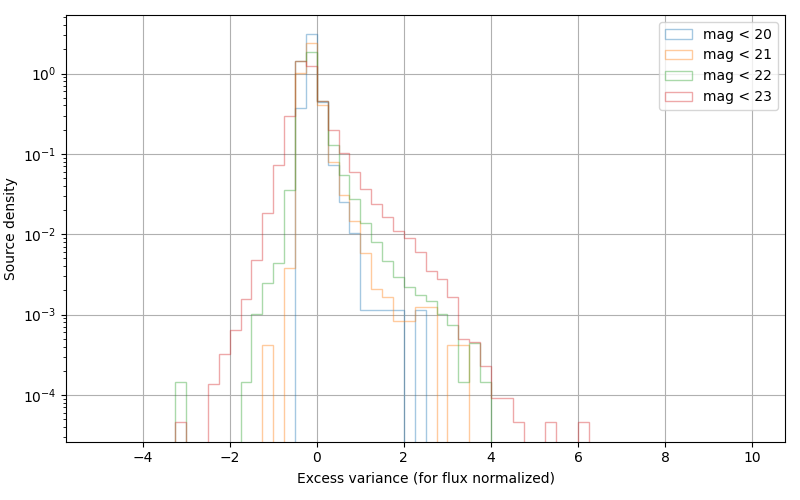

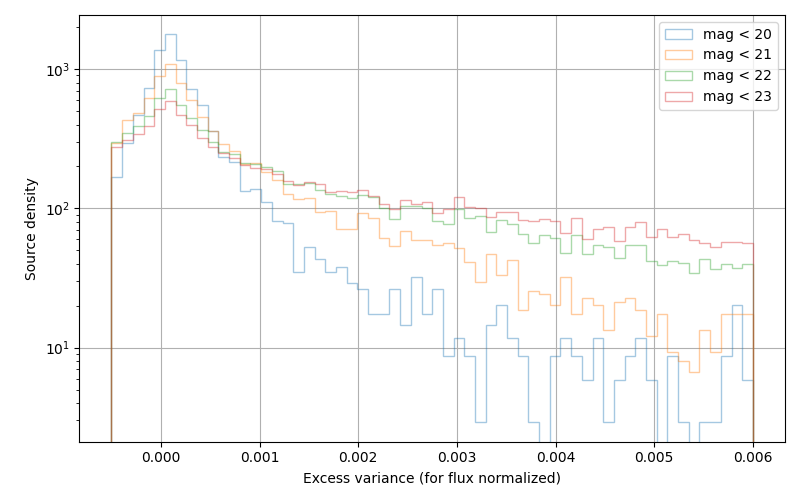

In [9]:
var_nxv = ["pos","flux"] #"pos" # 
nxv_bins = {"pos":np.linspace(-5, 10, 61),
            "flux":np.linspace(-0.0005, 0.006, 61)}
for var in var_nxv:
    # Plot excess variance for different magnitude levels
    fig_flux_nxv = plt.figure(num=var+"_nxv",figsize=(8, 5))
    for mag_cut in range(20,24):
        sel_mag = (tt_srcs["mag"]<mag_cut)
        if var == "pos":
            plt.hist(tt_srcs[sel_mag][var+"_xv"], bins=nxv_bins[var], density=True ,label="mag < "+str(mag_cut),alpha=0.4, histtype="step")   #, ,cumulative=1
        else:
            plt.hist(tt_srcs[sel_mag][var+"_nxv"], bins=nxv_bins[var], density=True ,label="mag < "+str(mag_cut),alpha=0.4, histtype="step")   #, ,cumulative=1
    plt.ylabel("Source density")
    plt.xlabel("Excess variance (for flux normalized)")
    plt.legend()
    plt.tight_layout()
    plt.semilogy()
    plt.grid()
    plt.show()

### Show coadd source flux difference variables

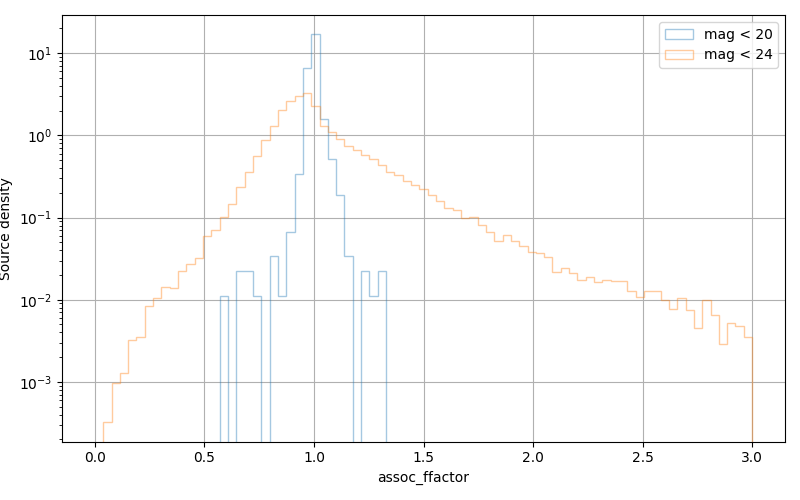

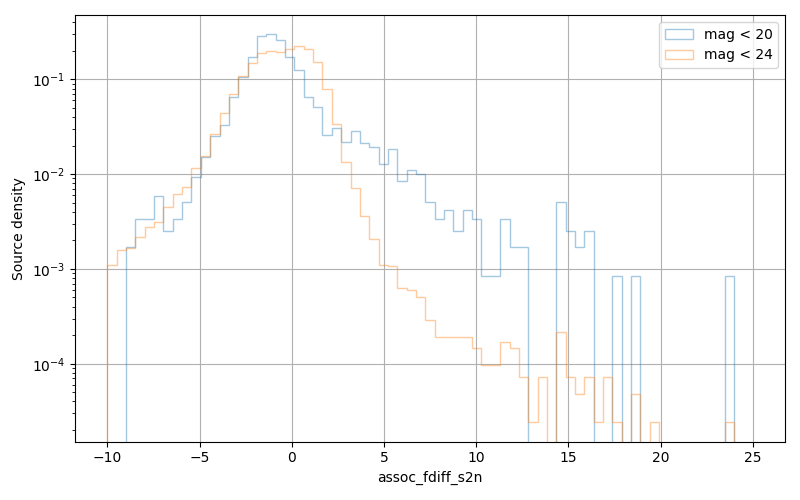

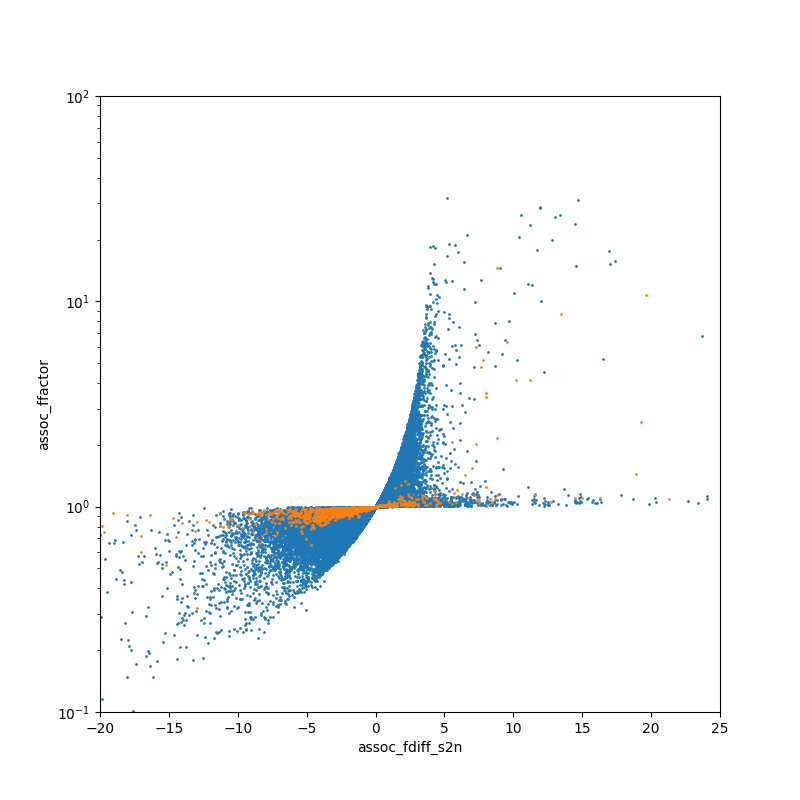

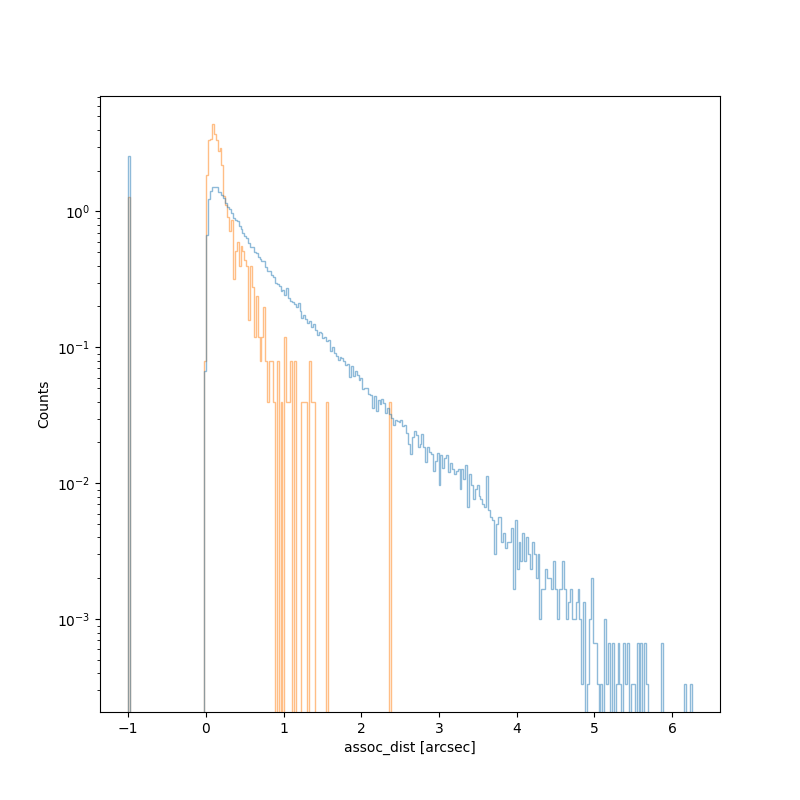

Fraction of sources with coadd 0.9374756145142411


In [10]:
var_assoc = ["assoc_ffactor","assoc_fdiff_s2n"] #"pos" # 
assoc_bins = {"assoc_ffactor":np.linspace(0, 3, 80),
            "assoc_fdiff_s2n":np.linspace(-10, 25, 70)}

for var in var_assoc:
    # Plot excess variance for different magnitude levels
    fig_assoc = plt.figure(num=var,figsize=(8, 5))
    for mag_cut in [20,24]: #range(20,24)
        sel_mag = (tt_srcs["mag"]<mag_cut)*(tt_srcs["mag"]>18)
        sel_ndet = tt_srcs["nr_fd_srcs"]==1
        
        sel = sel_ndet*sel_mag
        plt.hist(tt_srcs[sel][var], density=True ,label="mag < "+str(mag_cut),alpha=0.4, histtype="step",bins=assoc_bins[var])   #, ,cumulative=1, , nxv_bins[var]
    plt.ylabel("Source density")
    plt.xlabel(var)
    plt.legend()
    plt.tight_layout()
    plt.semilogy()
    plt.grid()
    plt.show()
        
fig_assoc_scat = plt.figure(num="assoc_scatter",figsize=(8, 8))
vvis.plot_table_scatter(tt_srcs,"assoc_fdiff_s2n","assoc_ffactor",xlim=[-20,25], ylim=[0.1,100], yscale="log")
plt.show()
fig_assoc_hist = plt.figure(num="assoc_hist",figsize=(8, 8))
vvis.plot_table_hist(tt_srcs,"assoc_dist")
plt.show()
    
frac_coadd = (tt_srcs["assoc_id"]>-1).sum()
print(f"Fraction of sources with coadd {frac_coadd  / len(tt_srcs)}")